## Importar librerias

In [1]:
import cv2
import math
import random
from moviepy.editor import *
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
import pathlib
import IPython.display as display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical, plot_model
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers, Sequential, Input
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K 

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Parametros

In [3]:
# Cantidad de Epocas para el entrenamiento
epochs = 50
# Especificar la resolucion de la imágenes del dataset
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Especificar el número de Frames que representan el video
SEQUENCE_LENGTH = 10

# Especificar el directorio de la base de datos
DATASET_DIR = './dataset/full'

# Especificar la lista de clases, en este caso la Ñ la reemplaza por NE para que no creara conflicto con el codigo
CLASSES_LIST = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "NE", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

# Especificar el Loss_rate y el momentum para el entrenamiento del modelo
lr = 0.001
momentum = 0.9

## Cargar Imagenes y Pre-Procesamiento

In [4]:
def frames_extraction(video_path):
    '''
    Esta función recupera las imagenes desde la base de datos las redimensiona a la resolucion especificada en parametros y las normaliza.
    Args:
        video_path: Ruta de la imagen en el directorio.
    Returns:
        frames_list: Una lista con los frames separados en el intervalo especificado en parámetros.
    '''

    # Declarar las variables
    frames_list = []
    
    frame_counter = 1

    # hacer una iteración para guardar los frames en el intervalo especificado
    for frame_counter in range(SEQUENCE_LENGTH):

        # Leer la imagen desde el directorio
        frame = cv2.imread(video_path) 

        # Redimensionar la imagen
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalizar la imagen entre 0 y 1
        normalized_frame = resized_frame / 255
        
        # Agregar elementos a la lista de frames
        frames_list.append(normalized_frame)
        
        frame_counter += 1

    # Retorna la frames list.
    return frames_list

In [5]:
def create_dataset():
    '''
    En esta funcion se va crear la base de datos con los frames extraidos del directorio.
    Returns:
        features:          Una lista con los frames extraidos.
        labels:            Una lista con las clases asociadas a cada imagen.
        video_files_paths: Una lista con el directorio donde están contenidas las imagenes.
    '''

    # Declarar las listas vacias para cada variable
    features = []
    labels = []
    video_files_paths = []
    
    # Se va a iterar sobre cada clase
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Para poder mostrar en que parte de la extracción va el codigo
        print(f'Extracting Data of Class: {class_name}')
        
        # Se crea la ruta de directorio con el nombre de cada clase 
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Se hace una iteración en la que se extraigan los frames pertenecientes a la clase
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            # Llamado de la funcion de extraccion
            frames = frames_extraction(video_file_path)

            # Revisar si los frames son iguales al parametro de tiempo
            if len(frames) == SEQUENCE_LENGTH:

                # Agregar la informacion a sus listas
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # convertir las listas a arreglos de numpy
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Retorna los frames, las clases y la ruta de archivos
    return features, labels, video_files_paths
            

In [6]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: A
Extracting Data of Class: B
Extracting Data of Class: C
Extracting Data of Class: D
Extracting Data of Class: E
Extracting Data of Class: F
Extracting Data of Class: G
Extracting Data of Class: H
Extracting Data of Class: I
Extracting Data of Class: J
Extracting Data of Class: K
Extracting Data of Class: L
Extracting Data of Class: M
Extracting Data of Class: N
Extracting Data of Class: NE
Extracting Data of Class: O
Extracting Data of Class: P
Extracting Data of Class: Q
Extracting Data of Class: R
Extracting Data of Class: S
Extracting Data of Class: T
Extracting Data of Class: U
Extracting Data of Class: V
Extracting Data of Class: W
Extracting Data of Class: X
Extracting Data of Class: Y
Extracting Data of Class: Z


In [7]:
one_hot_encoded_labels = to_categorical(labels)

In [8]:
# Se separa el dataset para el entrenamiento en 80% y validacion del 20%
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [9]:
K.clear_session()

## Creacion del Modelo, Heredando de MobileNet_v2

In [10]:
inp = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT , IMAGE_WIDTH, 3))

cnn = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3))

for layer in cnn.layers[:-30]:
	layer.trainable = False

headModel = TimeDistributed(cnn)(inp)

headModel = TimeDistributed(GlobalAveragePooling2D())(headModel)
headModel = Dense(256, activation="relu")(headModel)

headModel = TimeDistributed(Flatten())(headModel)

headModel = TimeDistributed(Dropout(0.5))(headModel)

headModel = LSTM(16)(headModel)
headModel = Dense(len(CLASSES_LIST), activation="softmax")(headModel)

model = Model(inputs=inp, outputs=headModel)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 1280)         0         
 tributed)                                                       
                                                                 
 dense (Dense)               (None, 10, 256)           327936    
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 256)          0         
 tributed)                                                       
                                                             

## Entrenamiento del Modelo

In [12]:
model.compile(
      optimizer=optimizers.SGD(lr, momentum), 
      #optimizer=optimizers.Adam(learning_rate=0.001),
      loss = 'categorical_crossentropy', 
      metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

early_stopper = EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
history = model.fit(x = features_train,
                    y = labels_train,
                    epochs=epochs,
                    validation_data = [features_test, labels_test],
                    callbacks=[early_stopper, reduce_lr])

Epoch 1/50
163/163 [==============================] - 261s 2s/step - loss: 3.1427 - accuracy: 0.1285 - val_loss: 3.0745 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 246s 2s/step - loss: 2.5650 - accuracy: 0.4325 - val_loss: 2.4991 - val_accuracy: 0.3269 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 242s 1s/step - loss: 1.8433 - accuracy: 0.6800 - val_loss: 1.7427 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 244s 1s/step - loss: 1.3634 - accuracy: 0.8098 - val_loss: 1.2723 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - 233s 1s/step - loss: 1.0830 - accuracy: 0.8608 - val_loss: 1.0154 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 229s 1s/step - loss: 0.8812 - accuracy: 0.9025 - val_loss: 0.8071 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 7/50
163/163 [==============================] - 243s 1s/st

In [13]:
model.save("CNN_LSTM_10_64_64_v1.h5")
print('ok')

ok


## Graficar precisión y perdida

In [14]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

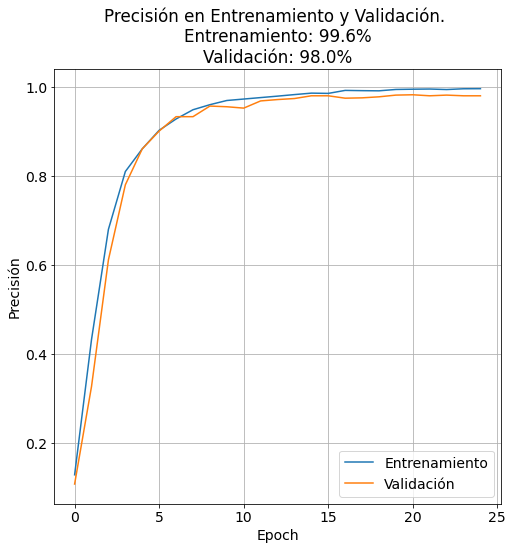

In [17]:
#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.legend(loc='lower right')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.title(f'Precisión en Entrenamiento y Validación. \nEntrenamiento: {str(round(acc[-1],4)*100)}%\nValidación: {str(round(val_acc[-1],3)*100)}%')
plt.savefig('CNN_LSTM_V2_Acc')

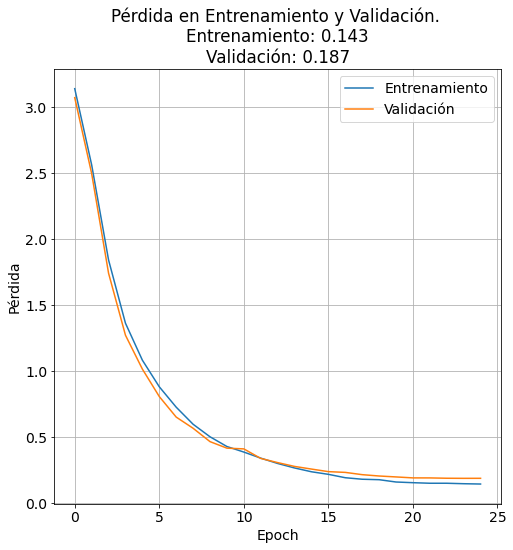

In [16]:
#loss
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.legend(loc='upper right')
plt.ylabel('Pérdida')
plt.title(f'Pérdida en Entrenamiento y Validación. \nEntrenamiento: {str(round(loss[-1],3))}\nValidación: {str(round(val_loss[-1],3))}')
plt.xlabel('Epoch')
plt.savefig('CNN_LSTM_V2_Loss')